<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/German_credit_exploratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from google.colab import drive
drive.mount('/content/drive')
! cd '/content/drive/MyDrive/Mirthe_Supervision /Paper#2/Colab Notebooks'

Mounted at /content/drive


# Explore data

In [28]:
credit = pd.read_csv('/content/drive/MyDrive/Mirthe_Supervision /Paper#2/Colab Notebooks/german_processed.csv')
credit.info()
credit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   GoodCustomer                     1000 non-null   int64 
 1   Gender                           1000 non-null   object
 2   ForeignWorker                    1000 non-null   int64 
 3   Single                           1000 non-null   int64 
 4   Age                              1000 non-null   int64 
 5   LoanDuration                     1000 non-null   int64 
 6   PurposeOfLoan                    1000 non-null   object
 7   LoanAmount                       1000 non-null   int64 
 8   LoanRateAsPercentOfIncome        1000 non-null   int64 
 9   YearsAtCurrentHome               1000 non-null   int64 
 10  NumberOfOtherLoansAtBank         1000 non-null   int64 
 11  NumberOfLiableIndividuals        1000 non-null   int64 
 12  HasTelephone                     10

,GoodCustomer,Gender,ForeignWorker,Single,Age,LoanDuration,PurposeOfLoan,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,...,OtherLoansAtBank,OtherLoansAtStore,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled
0,1,Male,0,1,67,6,Electronics,1169,4,4,...,0,0,0,0,1,0,0,0,1,1
1,-1,Female,0,0,22,48,Electronics,5951,2,2,...,0,0,0,0,1,0,0,0,0,1
2,1,Male,0,1,49,12,Education,2096,2,3,...,0,0,0,0,1,0,0,0,1,0
3,1,Male,0,1,45,42,Furniture,7882,2,4,...,0,0,0,1,0,0,0,0,1,1
4,-1,Male,0,1,53,24,NewCar,4870,3,4,...,0,0,0,0,0,0,0,0,0,1


In [29]:
credit['PurposeOfLoan'].unique()
credit['CheckingAccountBalance_geq_0'].unique()
credit['ForeignWorker'].unique()
credit['LoanDuration'].nunique()

33

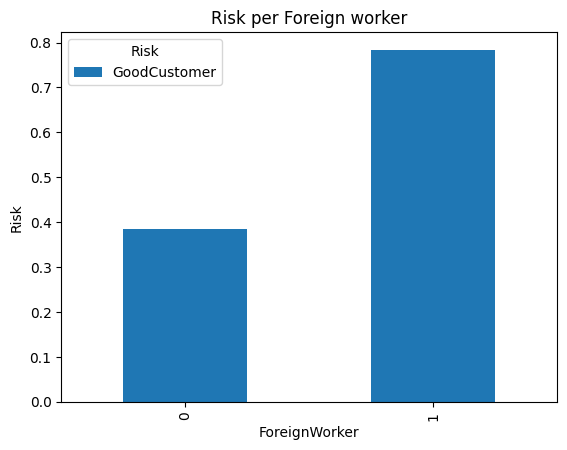

In [30]:
risk_per_foreign_worker = credit.groupby('ForeignWorker')['GoodCustomer'].mean()
risk_per_foreign_worker.plot(kind='bar', stacked=True)
plt.title('Risk per Foreign worker')

plt.xlabel('ForeignWorker')
plt.ylabel('Risk')
plt.legend(title='Risk')
plt.show()

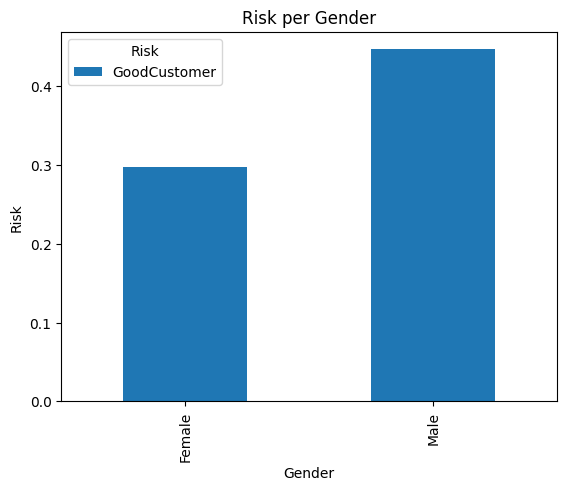

In [31]:
risk_per_gender = credit.groupby('Gender')['GoodCustomer'].mean()
risk_per_gender.plot(kind='bar', stacked=True)
plt.title('Risk per Gender')

plt.xlabel('Gender')
plt.ylabel('Risk')
plt.legend(title='Risk')
plt.show()

Text(0, 0.5, 'Risk')

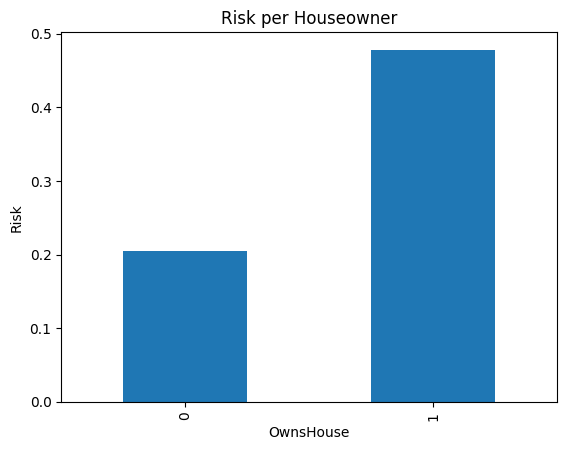

In [36]:
risk_per_houseowner = credit.groupby('OwnsHouse')['GoodCustomer'].mean()
risk_per_houseowner.plot(kind='bar', stacked=True)
plt.title('Risk per Houseowner')

plt.xlabel('OwnsHouse')
plt.ylabel('Risk')

# Master dataset

In [32]:
#Master dataset
#FEATURES
META = ['clusters', 'new_clusters', 'Error_Type']
ERROR = ['errors', 'TP', 'TN', 'FN', 'FP']
REG = ['Age', 'Single', 'Unemployed', 'OwnsHouse', 'LoanAmount']
SEN = ['Gender_F', 'ForeignWorker'] #protected attributes
DUMMY = ['']

#FEATURES SCALED
ERROR_scaled = ['errors_scaled']
REG_scaled = ['Age_scaled', 'Single_scaled', 'Unemployed_scaled',
              'OwnsHouse_scaled', 'LoanAmount_scaled']
SEN_scaled = ['Gender_F_scaled', 'ForeignWorker_scaled']
DUMMY_scaled = ['']

#SHAP FEATURES
SHAP_REG = ['Shap_Age', 'Shap_Single','Shap_Unemployed' 'Shap_OwnsHouse', 'Shap_LoanAmount']
SHAP_SEN = ['Shap_Gender_F', 'Shap_ForeignWorker']
SHAP_DUMMY = ['']

#SHAP FEATURES SCALED
SHAP_REG_scaled = ['Shap_Age_scaled', 'Shap_Single_scaled', 'Shap_Unemployed_scaled',
                   'Shap_OwnsHouse_scaled', 'Shap_LoanAmount_scaled']
SHAP_SEN_scaled = ['Shap_Gender_F_scaled', 'Shap_ForeignWorker_scaled']
SHAP_DUMMY_scaled = ['']



'''removed_features = 'LoanDuration','PurposeOfLoan','LoanRateAsPercentOfIncome', 'YearsAtCurrentHome',
'NumberOfOtherLoansAtBank', 'NumberOfLiableIndividuals', 'HasTelephone', 'CheckingAccountBalance_geq_0',
'CheckingAccountBalance_geq_200', 'SavingsAccountBalance_geq_100', 'SavingsAccountBalance_geq_500', 'MissedPayments',
'NoCurrentLoan', 'CriticalAccountOrLoansElsewhere', 'OtherLoansAtBank', 'OtherLoansAtStore', 'HasCoapplicant',
'HasGuarantor', 'RentsHouse', 'YearsAtCurrentJob_lt_1', 'YearsAtCurrentJob_geq_4', 'JobClassIsSkilled' '''

"removed_features = 'LoanDuration','PurposeOfLoan','LoanRateAsPercentOfIncome', 'YearsAtCurrentHome', \n'NumberOfOtherLoansAtBank', 'NumberOfLiableIndividuals', 'HasTelephone', 'CheckingAccountBalance_geq_0', \n'CheckingAccountBalance_geq_200', 'SavingsAccountBalance_geq_100', 'SavingsAccountBalance_geq_500', 'MissedPayments', \n'NoCurrentLoan', 'CriticalAccountOrLoansElsewhere', 'OtherLoansAtBank', 'OtherLoansAtStore', 'HasCoapplicant', \n'HasGuarantor', 'RentsHouse', 'YearsAtCurrentJob_lt_1', 'YearsAtCurrentJob_geq_4', 'JobClassIsSkilled' "

In [33]:
removed_features = ['LoanDuration','PurposeOfLoan','LoanRateAsPercentOfIncome', 'YearsAtCurrentHome',
'NumberOfOtherLoansAtBank', 'NumberOfLiableIndividuals', 'HasTelephone', 'CheckingAccountBalance_geq_0',
'CheckingAccountBalance_geq_200', 'SavingsAccountBalance_geq_100', 'SavingsAccountBalance_geq_500', 'MissedPayments',
'NoCurrentLoan', 'CriticalAccountOrLoansElsewhere', 'OtherLoansAtBank', 'OtherLoansAtStore', 'HasCoapplicant',
'HasGuarantor', 'RentsHouse', 'YearsAtCurrentJob_lt_1', 'YearsAtCurrentJob_geq_4', 'JobClassIsSkilled']

credit = credit.drop(removed_features, axis =1)
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   GoodCustomer   1000 non-null   int64 
 1   Gender         1000 non-null   object
 2   ForeignWorker  1000 non-null   int64 
 3   Single         1000 non-null   int64 
 4   Age            1000 non-null   int64 
 5   LoanAmount     1000 non-null   int64 
 6   OwnsHouse      1000 non-null   int64 
 7   Unemployed     1000 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 62.6+ KB


Get dummies for gender

In [34]:
credit['Gender_F'] = (credit['Gender'] == 'Female').astype(int)
credit['Gender_M'] = (credit['Gender'] == 'Male').astype(int)
credit = credit.drop('Gender', axis = 1)
credit.iloc[3]

,3
GoodCustomer,1
ForeignWorker,0
Single,1
Age,45
LoanAmount,7882
OwnsHouse,0
Unemployed,0
Gender_F,0
Gender_M,1


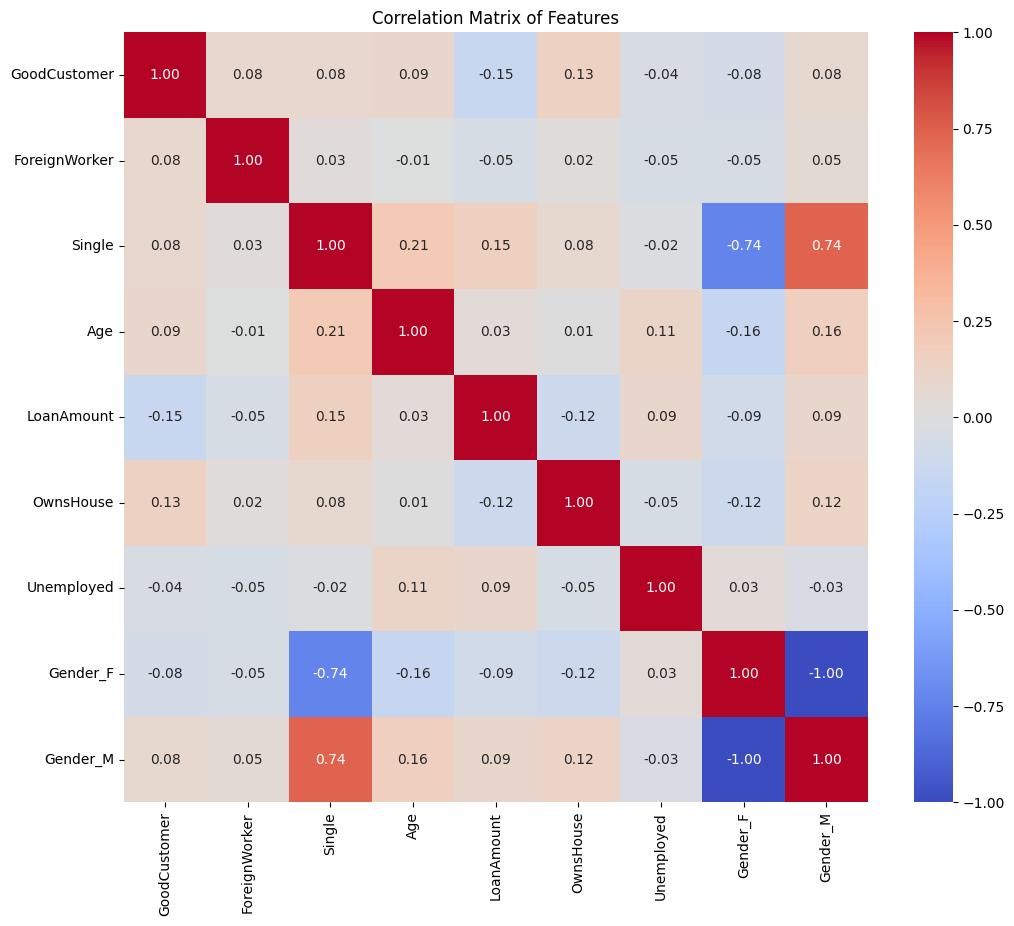

In [35]:
# Calculate correlation matrix for selected columns
correlation_matrix = credit.corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))  # Adjust figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()